In [1]:
import os

# Disable XLA globally (safe for both Q1 & Q2)
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir="
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

print(" Base environment configured")


 Base environment configured


### Question1 -  Lung X-Ray Dataset
Train a Convolutional Neural Network for Lung X-Ray Dataset using the training/validation/test split provided under dataset1.
- You may choose your own architecture to maximize performance in validation set (and by extension, the test set).
- Use the BinaryCrossentropy loss function.
- Use the sigmoid activation function in the output layer.
- Track two metrics: (1) BinaryAccuracy(threshold=0.5), and (2) AUC.
- Choose a learning algorithm and tune the learning rate adequately.
- Report performance results in training and validation sets.
- Display the learning curves.


#### loading the data 

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("bmh")


# Load ChestMNIST

chestdata = np.load("Project 3/chestmnist.npz")

X_train = chestdata["train_images"]   
t_train = chestdata["train_labels"]   

X_valid = chestdata["val_images"]
t_valid = chestdata["val_labels"]

X_test  = chestdata["test_images"]
t_test  = chestdata["test_labels"]

print("Train images:", X_train.shape, "Train labels:", t_train.shape)
print("Valid images:", X_valid.shape, "Valid labels:", t_valid.shape)
print("Test  images:", X_test.shape,  "Test  labels:", t_test.shape)


2025-12-03 20:39:22.583032: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train images: (78468, 28, 28) Train labels: (78468, 14)
Valid images: (11219, 28, 28) Valid labels: (11219, 14)
Test  images: (22433, 28, 28) Test  labels: (22433, 14)


#### preprocessing

In [3]:

# STEP 2 — PREPROCESSING (ChestMNIST)


import numpy as np

#  Normalize pixel values to [0, 1] 
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test  = X_test  / 255.0   # Not used in training, but preprocess now

# Add channel dimension (required for Conv2D) 
# Converts shape from (N, 28, 28) → (N, 28, 28, 1)
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

# Print shapes to confirm 
print("Train:", X_train.shape, t_train.shape)
print("Valid:", X_valid.shape, t_valid.shape)
print("Test: ", X_test.shape,  t_test.shape)


Train: (78468, 28, 28, 1) (78468, 14)
Valid: (11219, 28, 28, 1) (11219, 14)
Test:  (22433, 28, 28, 1) (22433, 14)


#### You may choose your own architecture to maximize performance in validation set (and by extension, the test set).
#### Use the BinaryCrossentropy loss function.
#### Use the sigmoid activation function in the output layer.
#### Track two metrics: (1) BinaryAccuracy(threshold=0.5), and (2) AUC.
#### Choose a learning algorithm and tune the learning rate adequately

In [4]:

# STEP 3 — Build CNN Model for ChestMNIST (TF 2.16 / Keras 3)


from keras import layers, models
import keras

def build_chest_model():
    inputs = keras.Input(shape=(28, 28, 1))

    # Block 1
    x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    # Block 2 
    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Block 3 
    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    #  Dense Layers 
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    #  Output Layer 
    outputs = layers.Dense(14, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="Chest_CNN")
    return model

model = build_chest_model()
model.summary()


2025-12-03 20:39:25.973802: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-12-03 20:39:25.974811: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2048 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:81:00.0, compute capability: 8.9
2025-12-03 20:39:25.974991: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-12-03 20:39:25.976002: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 20472 MB memory:  -> device: 1, name: NVIDIA L4, pci bus id: 0000:c1:00.0, compute capability: 8.9


Model: "Chest_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,886 (437.05 KB)

 Trainable params: 111,438 (435.30 KB)

 Non-trainable params: 448 (1.75 KB)

In [5]:

# STEP 4 — COMPILE MODEL (TF 2.16 / Keras 3)


from keras.metrics import BinaryAccuracy, AUC
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

metrics = [
    BinaryAccuracy(name="binary_accuracy", threshold=0.5),
    AUC(name="auc", multi_label=True)
]

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=BinaryCrossentropy(),
    metrics=metrics
)

model.summary()


Model: "Chest_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,886 (437.05 KB)

 Trainable params: 111,438 (435.30 KB)

 Non-trainable params: 448 (1.75 KB)

In [6]:

# STEP 5 — Train Model (ChestMNIST)


# Callbacks 
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "model_chest.keras",                 # saves best model
    save_best_only=True,
    monitor="val_binary_accuracy",
    mode="max"
)

earlystop_cb = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Train the model 
history = model.fit(
    X_train, t_train,
    epochs=30,
    batch_size=256,
    validation_data=(X_valid, t_valid),
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb],
    verbose=1
)

import pickle

# Save training history for ChestMNIST
with open("history_chest.pkl", "wb") as f:
    pickle.dump(history.history, f)


Epoch 1/30


I0000 00:00:1764812367.296845 2451237 service.cc:145] XLA service 0x55c1798cf4b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764812367.296880 2451237 service.cc:153]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
I0000 00:00:1764812367.296882 2451237 service.cc:153]   StreamExecutor device (1): NVIDIA L4, Compute Capability 8.9
2025-12-03 20:39:27.335594: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-03 20:39:27.494683: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 51/307 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.5076 - binary_accuracy: 0.7796 - loss: 0.4774

I0000 00:00:1764812369.662283 2451237 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.5374 - binary_accuracy: 0.8976 - loss: 0.2907

I0000 00:00:1764812373.676416 2451298 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_122', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1764812374.013848 2451298 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_122', 12 bytes spill stores, 20 bytes spill loads

I0000 00:00:1764812374.085123 2451299 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_122', 40 bytes spill stores, 64 bytes spill loads

I0000 00:00:1764812375.412892 2451299 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_129', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1764812377.077919 2451344 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_122', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1764812378.127485 2451345 asm

307/307 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - auc: 0.5374 - binary_accuracy: 0.8977 - loss: 0.2905 - val_auc: 0.4871 - val_binary_accuracy: 0.9492 - val_loss: 0.1955 - learning_rate: 0.0010
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.6113 - binary_accuracy: 0.9484 - loss: 0.1808 - val_auc: 0.6412 - val_binary_accuracy: 0.9492 - val_loss: 0.1749 - learning_rate: 0.0010
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.6475 - binary_accuracy: 0.9485 - loss: 0.1745 - val_auc: 0.6782 - val_binary_accuracy: 0.9492 - val_loss: 0.1750 - learning_rate: 0.0010
Epoch 4/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.6756 - binary_accuracy: 0.9481 - loss: 0.1720 - val_auc: 0.6884 - val_binary_accuracy: 0.9492 - val_loss: 0.1750 - learning_rate: 0.0010
Epoch 5/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.6895 - binary_accuracy: 0.9490 - loss: 0.1683 - val_auc: 0.7195 - val_binary_accuracy: 0.9491 - val_loss: 0.1661 - learning_rate: 0.0010
Epoch 6/30
307/307

#### Report performance results in training and validation sets.


In [7]:

# FINAL TRAINING AND VALIDATION METRICS (LOSS, ACC, AUC)


# Evaluate on training data
train_loss, train_acc, train_auc = model.evaluate(X_train, t_train, verbose=0)

# Evaluate on validation data
val_loss, val_acc, val_auc = model.evaluate(X_valid, t_valid, verbose=0)

print("\n TRAINING RESULTS ")
print(f"Training Loss:            {train_loss:.4f}")
print(f"Training Binary Accuracy: {train_acc:.4f}")
print(f"Training AUC:             {train_auc:.4f}")

print("\n VALIDATION RESULTS ")
print(f"Validation Loss:            {val_loss:.4f}")
print(f"Validation Binary Accuracy: {val_acc:.4f}")
print(f"Validation AUC:             {val_auc:.4f}")



 TRAINING RESULTS 
Training Loss:            0.1503
Training Binary Accuracy: 0.9496
Training AUC:             0.8084

 VALIDATION RESULTS 
Validation Loss:            0.1583
Validation Binary Accuracy: 0.9495
Validation AUC:             0.7559


#### Display the learning curves.

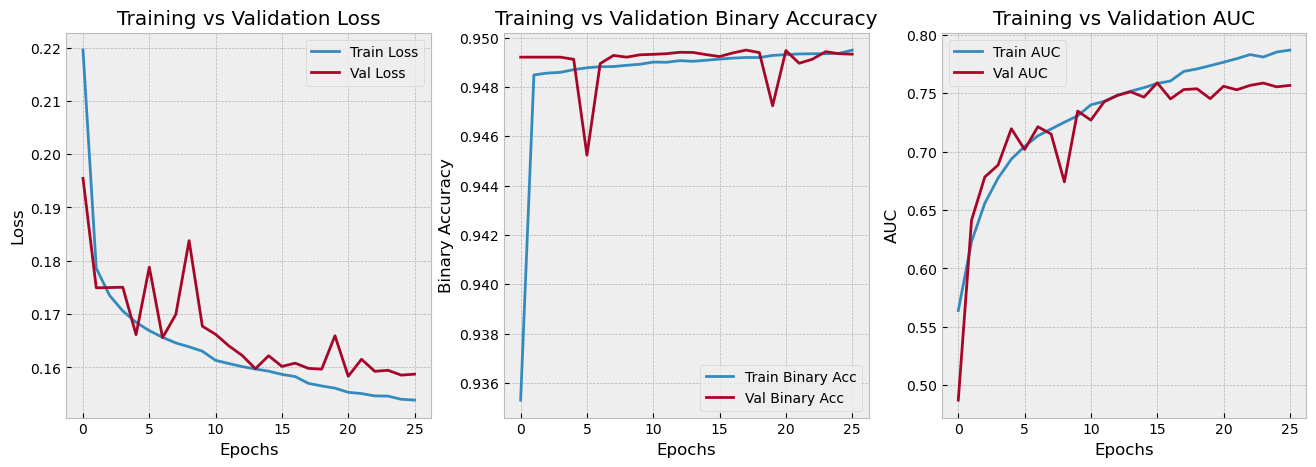

In [8]:

# STEP 6 — Learning Curves (Loss, Binary Accuracy, AUC)


hist = history.history

plt.figure(figsize=(16,5))

# Loss 
plt.subplot(1,3,1)
plt.plot(hist["loss"], label="Train Loss")
plt.plot(hist["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Binary Accuracy 
plt.subplot(1,3,2)
plt.plot(hist["binary_accuracy"], label="Train Binary Acc")
plt.plot(hist["val_binary_accuracy"], label="Val Binary Acc")
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.title("Training vs Validation Binary Accuracy")
plt.legend()

# AUC 
plt.subplot(1,3,3)
plt.plot(hist["auc"], label="Train AUC")
plt.plot(hist["val_auc"], label="Val AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.title("Training vs Validation AUC")
plt.legend()

plt.show()


## Question 2

Train a Convolutional Neural Network for Retina Dataset using the training/validation/test split provided under dataset 2.
- You may choose your own architecture to maximize performance in validation set (and by extension, the test set).
- Decide on the most appropriate loss function, activation function at the output layer, learning algorithm, and the learning rate.
- Track two metrics: (1) Accuracy, and (2) AUC.
- Report performance results in training and validation sets.
- Display the learning curves.


In [9]:
import os

# Disable XLA (required!!)
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir="
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers

plt.style.use("bmh")

print("TF:", tf.__version__)
print("Keras:", keras.__version__)
print("Devices:", tf.config.list_physical_devices("GPU"))


TF: 2.16.1
Keras: 3.3.3
Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [11]:
import tensorflow as tf
print(tf.config.list_physical_devices("GPU"))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


 #### Load RetinaMNIST Dataset

In [12]:
#  Load RetinaMNIST Dataset


import numpy as np

retina = np.load("Project 3/retinamnist_128.npz")

X_train_r = retina["train_images"]     # (1080,128,128,3)
t_train_r = retina["train_labels"]     # (1080,1)

X_valid_r = retina["val_images"]       # (120,128,128,3)
t_valid_r = retina["val_labels"]       # (120,1)

X_test_r  = retina["test_images"]      # (400,128,128,3)
t_test_r  = retina["test_labels"]      # (400,1)

print("Train:", X_train_r.shape, t_train_r.shape)
print("Valid:", X_valid_r.shape, t_valid_r.shape)
print("Test:",  X_test_r.shape,  t_test_r.shape)


Train: (1080, 128, 128, 3) (1080, 1)
Valid: (120, 128, 128, 3) (120, 1)
Test: (400, 128, 128, 3) (400, 1)


 #### Preprocess Retina Images

In [13]:

#  Preprocess Retina Images


# Scale images to [0, 1]
X_train_r = X_train_r / 255.0
X_valid_r = X_valid_r / 255.0
X_test_r  = X_test_r  / 255.0

# Flatten labels to shape (N,)
t_train_r = t_train_r.reshape(-1)
t_valid_r = t_valid_r.reshape(-1)
t_test_r  = t_test_r.reshape(-1)

print("Sparse labels:", t_train_r.shape, t_valid_r.shape, t_test_r.shape)

# ---- NEW: convert to one-hot for 5 classes ----
from keras.utils import to_categorical

num_classes = 5
t_train_r_oh = to_categorical(t_train_r, num_classes=num_classes).astype("float32")
t_valid_r_oh = to_categorical(t_valid_r, num_classes=num_classes).astype("float32")
t_test_r_oh  = to_categorical(t_test_r,  num_classes=num_classes).astype("float32")

print("One-hot labels:", t_train_r_oh.shape, t_valid_r_oh.shape, t_test_r_oh.shape)


Sparse labels: (1080,) (120,) (400,)
One-hot labels: (1080, 5) (120, 5) (400, 5)


In [14]:
#  Undo when class balanced needed
#from sklearn.utils.class_weight import compute_class_weight
#import numpy as np

## Original labels (0–4)
#y_train_raw = t_train_r  

## Compute balanced weights
#class_weights = compute_class_weight(
#    class_weight="balanced",
#    classes=np.unique(y_train_raw),
#    y=y_train_raw
#)

# Convert to dictionary {class_index: weight}
#class_weights = {i: w for i, w in enumerate(class_weights)}

#print("Class Weights:", class_weights)


#### You may choose your own architecture to maximize performance in validation set (and by extension, the test set).
#### Decide on the most appropriate loss function, activation function at the output layer, learning algorithm, and the learning rate.

In [15]:

# Build CNN Model for RetinaMNIST


def build_retina_model():
    inputs = keras.Input(shape=(128, 128, 3))

    # Block 1
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Block 2
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Block 3
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Block 4
    x = layers.Conv2D(256, (3,3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)  # reduces to (batch, 256)

    # Dense layers
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    # Output layer: 5 classes, softmax
    outputs = layers.Dense(5, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="Retina_CNN")
    return model

model_r = build_retina_model()
model_r.summary()


Model: "Retina_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,877 (1.62 MB)

 Trainable params: 422,917 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [16]:

# STEP 4 — Compile Retina Model (one-hot labels)


from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, AUC

model_r.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(),             
    metrics=[
        CategoricalAccuracy(name="accuracy"),    
        AUC(name="auc", multi_label=True)         
    ],
    run_eagerly=True  
# avoid tf2xla / UnsortedSegmentSum weirdness
)

model_r.summary()


Model: "Retina_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,877 (1.62 MB)

 Trainable params: 422,917 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

#### Track two metrics:  Accuracy, and  AUC.

In [17]:

# STEP 5 — Train Model (RetinaMNIST)


checkpoint_r = keras.callbacks.ModelCheckpoint(
    "model_retina.keras",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

earlystop_r = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr_r = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

history_r = model_r.fit(
    X_train_r, t_train_r_oh,        
    epochs=30,
    batch_size=32,
    validation_data=(X_valid_r, t_valid_r_oh),
    callbacks=[checkpoint_r, earlystop_r, reduce_lr_r],
   verbose=1
)

#history_r = model_r.fit(
#    X_train_r,
#    t_train_r_oh,
#    epochs=25,
#    batch_size=32,
#    validation_data=(X_valid_r, t_valid_r_oh),
#    class_weight=class_weights,      
#    callbacks=[checkpoint_r, earlystop_r, reduce_lr_r],
#    verbose=1
#)

# SAVE RETINA MODEL + TRAINING HISTORY


# Save model
model_r.save("model_retina.keras")

# Save history
import pickle
with open("history_retina.pkl", "wb") as f:
    pickle.dump(history_r.history, f)

print("RetinaMNIST model & history saved")


Epoch 1/30
 2/34 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.1562 - auc: 0.5856 - loss: 1.7924WARNING:tensorflow:5 out of the last 5 calls to <function pfor.<locals>.f at 0x14cfa69965c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.3320 - auc: 0.6218 - loss: 1.5442 - val_accuracy: 0.3167 - val_auc: 0.5467 - val_loss: 1.5843 - learning_rate: 1.0000e-04
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.

#### Report performance results in training and validation sets.

In [18]:

#  Final Train/Validation Metrics


train_metrics = model_r.evaluate(X_train_r, t_train_r_oh, verbose=0)
val_metrics   = model_r.evaluate(X_valid_r, t_valid_r_oh, verbose=0)

print("Train set – Loss: {:.4f}, Accuracy: {:.4f}, AUC: {:.4f}"
      .format(train_metrics[0], train_metrics[1], train_metrics[2]))
print("Valid set – Loss: {:.4f}, Accuracy: {:.4f}, AUC: {:.4f}"
      .format(val_metrics[0],   val_metrics[1],   val_metrics[2]))


Train set – Loss: 1.0429, Accuracy: 0.5731, AUC: 0.8352
Valid set – Loss: 1.0154, Accuracy: 0.6083, AUC: 0.8240


#### Display the learning curves.

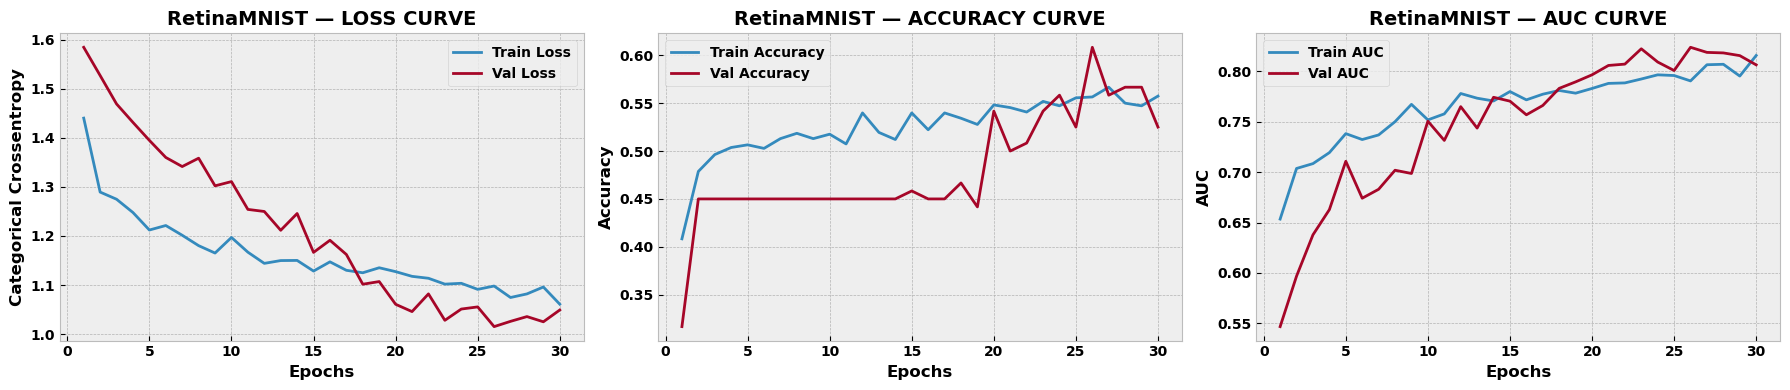

In [19]:
import matplotlib.pyplot as plt

hist_r = history_r.history
epochs = range(1, len(hist_r['loss']) + 1)

plt.figure(figsize=(18, 4))

# Set global bold tick labels
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['font.weight'] = 'bold'   
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

# 1. LOSS 
plt.subplot(1, 3, 1)
plt.plot(epochs, hist_r["loss"], label="Train Loss")
plt.plot(epochs, hist_r["val_loss"], label="Val Loss")
plt.title("RetinaMNIST — LOSS CURVE", fontsize=14, fontweight="bold")
plt.xlabel("Epochs", fontsize=12, fontweight="bold")
plt.ylabel("Categorical Crossentropy", fontsize=12, fontweight="bold")
plt.legend(prop={'weight': 'bold', 'size': 10})

# 2. ACCURACY 
plt.subplot(1, 3, 2)
plt.plot(epochs, hist_r["accuracy"], label="Train Accuracy")
plt.plot(epochs, hist_r["val_accuracy"], label="Val Accuracy")
plt.title("RetinaMNIST — ACCURACY CURVE", fontsize=14, fontweight="bold")
plt.xlabel("Epochs", fontsize=12, fontweight="bold")
plt.ylabel("Accuracy", fontsize=12, fontweight="bold")
plt.legend(prop={'weight': 'bold', 'size': 10})

# 3. AUC 
plt.subplot(1, 3, 3)
plt.plot(epochs, hist_r["auc"], label="Train AUC")
plt.plot(epochs, hist_r["val_auc"], label="Val AUC")
plt.title("RetinaMNIST — AUC CURVE", fontsize=14, fontweight="bold")
plt.xlabel("Epochs", fontsize=12, fontweight="bold")
plt.ylabel("AUC", fontsize=12, fontweight="bold")
plt.legend(prop={'weight': 'bold', 'size': 10})

plt.tight_layout()
plt.show()
